<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets

    
- Determine water body polygons


- Build the Digital Elevation Model



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True.</font> <br>
<font size=5 color='blue'> If you are running on your own computer, set the variable yes_colab = False </font>


In [1]:
yes_colab = False


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [2]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')
if yes_colab:
    where_to_mount = '/content/drive/'
    from google.colab import drive
    drive.mount(where_to_mount, force_remount=True)
    mounted_drive = Path(where_to_mount) / 'MyDrive' 
    sys.path.append(str(mounted_drive / 'installations'))
    path_ancillary = mounted_drive / 'ancillary'
    Path(mounted_drive / 'installations').mkdir(parents=True, exist_ok=True)

else:
    mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))



Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [3]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


In [4]:
if yes_colab:
  print('\n## Installing the Python packages needed for these tutorials\n')
  try:
    import geopandas as gpd
  except:
    !/bin/bash $mounted_drive/BAM/notebooks/install_packages_colab_debug.sh


In [5]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts/'
path_templates = mounted_drive /  'templates/'
path_configs = mounted_drive / 'configs/'
sys.path.insert(1,str(path_code))
print(path_code)
print(path_ancillary)

path_examples = mounted_drive / 'examples'
path_examples.mkdir(parents=True, exist_ok=True)

/Users/alchrist/Documents/GitHub/BAM/scripts
/Users/alchrist/Documents/GitHub/BAM/ancillary


In [6]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
from scipy import *


In [7]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)

# Standard packages

import fnmatch
from pathlib import Path
import geopandas as gpd

## Plotting modules
import matplotlib.pyplot as plt

## Google Earth Packages
import ee
from ee import batch

import zipfile



/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size=6> Step #1c: Choose to run the Demo or set up your own AOI. If running demo, unzip example files in Komo.zip <font> 




In [8]:
demo = False
if demo:
    with zipfile.ZipFile("komo_starter.zip", 'r') as zip_ref:
        zip_ref.extractall(path_examples)
    AOI = 'komo'
else:
    AOI = 'magdalena'

<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


AOI should match the name of the folder where files will be saved

In [9]:


Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is magdalena
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 

In [10]:
run_gee = True

In [11]:
if run_gee:
    # Trigger the authentication flow.
    ee.Authenticate()

    # Initialize the library.
    ee.Initialize()

In [12]:
# # ## Create a map for defining area of interest
# Map = geemap.Map()
# Map


In [13]:
def maskS2clouds(image):
    qa = image.select('QA60');
    ##Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    ##Both flags should be set to zero, indicating clear conditions.
    cloudmask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    #cloudmask = qa.bitwiseAnd(cloudBitMask).eq(0)*(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(cloudmask)#.divide(10000)
    #return image.updateMask(qa.bitwiseAnd(cloudBitMask).eq(0)).updateMask(qa.bitwiseAnd(cirrusBitMask).eq(0)).divide(100000)  
def addNDWI(image):
  ndwi = image.normalizedDifference(['B8', 'B3']).rename('NDWI').toFloat();
  return image.addBands(ndwi)    
def addNDVI(image):
  #ndvi = image.normalizedDifference(['B8', 'B3']).rename('NDVI').toFloat();
  ndvi = (image.select(['B8']).subtract(image.select(['B3']))).divide(image.select(['B8']).add(image.select(['B3']))).rename('NDVI')
  return image.addBands(ndvi)
def addMNDWI(image):
  mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI');
  return image.addBands(mndwi)

## GEEMAP is no longer compatible with other python dependencies. The extent shapefile must be provided and saved in the User_Defined_Files folder

In [14]:
extent_file  = folders[0] / ('%s_input.shp' %(AOI))

# if os.path.isfile(extent_file)==True:
#     print('Model domain defined by %s' %(extent_file))
#     ee_object = geemap.shp_to_ee(extent_file)
# #     Map.addLayer(ee_object, {}, 'Layer name')
# #     Map.centerObject(ee_object,7)
# else: 
#     print('You must create a shapefile defining the extent of your AOI')
#     # print('You must define the model domain using the map above')
#     # Map.draw_last_feature
#     # roi = ee.FeatureCollection(Map.draw_features)
#     # geemap.ee_export_vector(roi, '/Users/alchrist/downloads/test.shp')

In [15]:
extent_gpd = gpd.read_file(extent_file)
resolution  = 10 ## resolution of the water mask

if extent_gpd.crs == None:
    extent_gpd = extent_gpd.set_crs('EPSG:4326')
if extent_gpd.crs != 'EPSG:4326':
    print('reprojecting to EPSG')
    extent_gpd = extent_gpd.to_crs('EPSG:4326')

extent_gpd.geometry = extent_gpd.buffer(0.2,join_style = 2)
exterior_points = extent_gpd.geometry[0].exterior.coords[:]
exterior_points = list(map(list, exterior_points))
ee_poly = ee.Geometry.Polygon(coords=exterior_points)    

# Map.addLayer(ee_poly)

/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_26392/1136949929.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extent_gpd.geometry = extent_gpd.buffer(0.2,join_style = 2)


In [16]:
collectionS2 = ee.ImageCollection("COPERNICUS/S2")\
    .filter(ee.Filter.calendarRange(2019,2022,'year'))\
    .filter(ee.Filter.calendarRange(1,12,'month'))\
    .filterBounds(ee_poly)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))\
    .map(addNDWI)\
    .map(addMNDWI)\
    .map(addNDVI)\
    .map(maskS2clouds)  ;  
collectionVV = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.calendarRange(2019,2022,'year'))\
    .filter(ee.Filter.calendarRange(1,12,'month'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filterMetadata('resolution_meters', 'equals' , 10)\
    .filterBounds(ee_poly)\
    .select('VV');
collectionVH = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.calendarRange(2019,2022,'year'))\
    .filter(ee.Filter.calendarRange(1,12,'month'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filterMetadata('resolution_meters', 'equals' , 10)\
    .filterBounds(ee_poly)\
    .select('VH');

/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/ee/deprecation.py:202: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


In [17]:
## Process Sentinel-1 Data
VV_ref = collectionVV.max().focal_mean(30, 'circle', 'meters')
VH_ref = collectionVH.max().focal_mean(30, 'circle', 'meters')

# Process Sentinel-2 Data
S2_max = collectionS2.max()    
S2_min = collectionS2.min()
S2_mean = collectionS2.mean()    
ndwi_min = S2_min.select('NDWI')
ndvi_min = S2_min.select('NDVI')   
ndwi_max = S2_max.select('NDWI')
ndvi_max = S2_max.select('NDVI')   
ndwi_mean = S2_mean.select('NDWI')
ndvi_mean = S2_mean.select('NDVI')   



In [18]:
folder_on_drive = 'gee_' + AOI

In [19]:
if run_gee:

    ## NDWI max, VV, and VH composite
    bands = ['NDWI','VV','VH'];
    ref_composite = ee.Image.cat(ndwi_max.toFloat(),VV_ref.toFloat(),VH_ref.toFloat()).select(bands).clip(ee_poly);
    method = 'ndwimax_vvvhmax'
    print('Method is %s' %(method))

    ## Save composite
    # comp_out1 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    # process = batch.Task.start(comp_out1)
    # print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=resolution,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out1 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out1)
    print('Saved clusters to Google Drive at %s/%s_%s' %(folder_on_drive,AOI,method))

else:
    print('Skipping')

Method is ndwimax_vvvhmax
Saved clusters to Google Drive at gee_magdalena/magdalena_ndwimax_vvvhmax


In [20]:
if run_gee:
    ## Save S2 mean VV and VH max
    bands = ['NDWI','VV','VH'];
    ref_composite = ee.Image.cat(ndwi_mean.toFloat(),VV_ref.toFloat(),VH_ref.toFloat()).select(bands).clip(ee_poly);
    method = 'ndwimean_vvvhmax'
    print('Method is %s' %(method))

    ## Save composite
    # comp_out2 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    # process = batch.Task.start(comp_out2)
    # print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=resolution,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out2 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out2)
    print('Saved clusters to Google Drive at GEE_drive_masks/%s_%s' %(AOI,method))

else:
    print('Skipping')


Method is ndwimean_vvvhmax
Saved clusters to Google Drive at GEE_drive_masks/magdalena_ndwimean_vvvhmax


In [21]:
if run_gee: 
    ## Save NDVI and NDWI min
    bands = ['NDVI','NDWI'];
    ref_composite = ee.Image.cat(ndvi_min.toFloat(),ndwi_min.toFloat()).select(['NDWI','NDVI']).clip(ee_poly);      
    method = 'ndvimin_ndwimin'
    print('Method is %s' %(method))

    ## Save composite
    # comp_out3 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    # process = batch.Task.start(comp_out3)
    # print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=resolution,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out3 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out3)
    print('Saved clusters to Google Drive at GEE_drive_masks/%s_%s' %(AOI,method))

else:
    print('Skipping')

Method is ndvimin_ndwimin
Saved clusters to Google Drive at GEE_drive_masks/magdalena_ndvimin_ndwimin


In [22]:
if run_gee:
    ## Save NDVI and NDWI max
    bands = ['NDVI','NDWI'];
    ref_composite = ee.Image.cat(ndvi_max.toFloat(),ndwi_max.toFloat()).select(['NDWI','NDVI']).clip(ee_poly);      
    method = 'ndvimax_ndwimax'
    print('Method is %s' %(method))

    ## Save composite
    #comp_out4 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    #process = batch.Task.start(comp_out4)
    #print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=resolution,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out4 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out4)
    print('Saved clusters to Google Drive at GEE_drive_masks/%s_%s' %(AOI,method))

else:
    print('Skipping')


Method is ndvimax_ndwimax
Saved clusters to Google Drive at GEE_drive_masks/magdalena_ndvimax_ndwimax


In [23]:

ref_res = 10
res = 10

configfile = path_configs / 'Deltas_SetupParameters_MASTER_V2.csv' # #'Deltas_SetupParameters_MASTER_V2.csv'path_configs + 'need_opening.csv'#'
parameter_file = pd.read_csv(configfile)
AOIs = parameter_file['AOI']


AOI = AOI.lower()
parameters = parameter_file[parameter_file['AOI']==AOI.capitalize()].reset_index(drop=True)

parameters.to_csv(folders[6] / ('config_%s.csv' %(AOI)))
## Set up working directory and build sub folders if needed
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))
working_path,folders = build_directory(path_examples, AOI)





Study area is magdalena
Resolution of this setup is 10m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 

In [24]:
final_watermasks = [os.path.join(dirpath,f)
    for dirpath,dirnames, files in os.walk(Path(path_examples) /AOI/'User_Defined_Files')
    for f in fnmatch.filter(files,'*_finalwatermask.tif')]

print(final_watermasks)


['/Users/alchrist/Documents/GitHub/BAM/examples/magdalena/User_Defined_Files/magdalena_ndvimin_ndwimin_clustered_finalwatermask.tif']


<font size='6' > Step #3: Configuration Parameters </font>


In [25]:
try:
    parameters = pd.read_csv(folders[6] / ('config_%s.csv' %(AOI)))
except:    
    parameters = pd.DataFrame()
    parameters['AOI'] = [AOI]
    parameters['RiverOceanBoundary'] = '1260'
    parameters['Discharge'] = '426'

    #Method parameters:
    parameters['LandcoverMethod'] = 'WorldCover'
    parameters['LandElevMethod'] = 'GLO30'
    parameters['OceanElevMethod'] = 'GEBCO'
    parameters['LowerRiverElevMethod'] = 'plane'
    parameters['UpperRiverElevMethod'] = 'wdpower'
    parameters['WetlandElevMethod'] = 'constant_0.5'
    parameters['LakeElevMethod'] = 'constant_1'
    parameters['ManningLUT'] = 'default'
    parameters['WetlandClass'] = '90'

    #Coefficients for determining bathymetry:
    parameters['WD_POWERA_upper'] = '0.0606'
    parameters['WD_POWERB_upper'] = '0.7732'

    #Max thresholds:
    parameters['MaxOceanDepth'] = '-300'
    parameters['MaxNearshoreDepth'] = '-300'
    parameters['MaxRiverDepth'] = '-300'
    parameters['MaxRiverWidth'] = '756'



If you didn't run the Download notebook, the following cells will won't work. Go back to that notebook and download ancillary data.

In [26]:
try:
    ref_10m = rasterio.open('%s_GEBCO_%s.tif' %(folders[8] / AOI,res))
except:
    ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)





##############################################################################################
##############################[Step 1b][GetExtentParameters]##################################
##############################################################################################

##################### AOI extent is set by: magdalena_input.shp

[Step 2][Setup_AOI_Files][Determine EPSG code and UTM zone] .......

##################### ANUGA Models must be in UTM
##################### UTM Zone: 18n
##################### EPSG: 32218 

[Step 2][Setup_AOI_Files][Extending AOI by 1000m] .......


[Step 2][Setup_AOI_Files][Setting up AOI extent] .......

##################### AOI bounds are : 498950, 1134220, 598890, 1250270
##################### Approximate area of AOI extent is 11598.0 km^2

[Step 2][Setup_AOI_Files][Downloading GEBCO Dataset as reference for projection, resolution, etc] .......


[Step 2][Setup_AOI_Files][Saving configuration file] .......

##################### Sav

Text(0.5, 1.0, 'GEBCO Bathymetry resampled to 10m resolution')

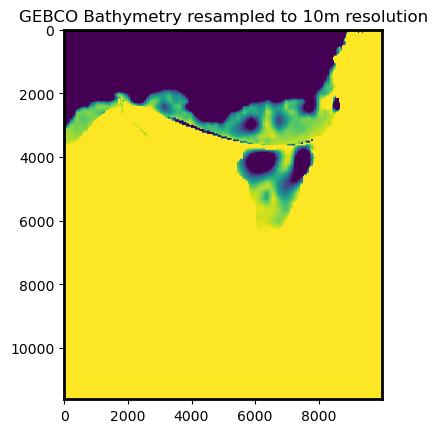

In [27]:
plt.imshow(ref_10m.read(1),vmin=-50,vmax=0)
plt.title('GEBCO Bathymetry resampled to 10m resolution')

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [28]:
parameters = pd.read_csv(folders[2] / ('%s_Configuration.csv' %(AOI)))
print(parameters.iloc[0] )

Unnamed: 0.1                                  0
Unnamed: 0                                    0
AOI                                   Magdalena
area_m2                           11200000000.0
perimeter_m                           423526.36
RiverOceanBoundary                          0.0
Discharge                                2000.0
ExtentFile                  Magdalena_input.shp
LandcoverMethod                      WorldCover
LandElevMethod                            GLO30
OceanElevMethod                           GEBCO
LowerRiverElevMethod                      plane
UpperRiverElevMethod                    wdpower
WetlandElevMethod                    constant_0
LakeElevMethod                       constant_1
ManningLUT                              default
WetlandClass                               90.0
BEDINTERCEPT_lower                      0.00004
BEDSLOPE_lower                         0.000006
BEDINTERCEPT_upper                      0.00004
BEDSLOPE_upper                         0

<font size='6' > Step #4: Download datasets </font>
<br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [29]:
ref = setup_AOI_files(your_path,
                    AOI,
                    folders,
                    res,
                    parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

##################### Reference raster is magdalena_GEBCO_10.tif
##################### This profile will be used for all future warping
##################### Resolution is 10m

[Step 2][Setup_AOI_Files][Compiling OCEAN elevation dataset] .......

##################### Ocean elevation set with:  GEBCO
##################### Saving Ocean Bathymetry file as /Setup_Files/Setup_RSTmagdalena_bathy_10.tif

[Step 2][Setup_AOI_Files][Compiling LAND elevation dataset] .......

##################### Land elevation set with: GLO30
##################### Downloading Tandem-X GLO30
X = 74
North Y = 9
contents of URL written to GLO30_n09w074.tif
North Y = 10
contents of URL written to GLO30_n10w074.tif
North Y = 11
con

  0%|          | 0/2 [00:00<?, ?it/s]

##################### Merging landcover tiles
0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 2][Setup_AOI_Files][Loading Global Mangrove Watch ] .......

There are no mangroves in the magdalena domain


/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(



[Step 3A][Make_Watermask][Delineating wetland areas] ......



ERROR 5: Source and destination datasets must be different.




[Step 3A][Make_Watermask][Delineating agriculture areas] ......



ERROR 5: Source and destination datasets must be different.




[Step 2][Setup_AOI_Files] Finished .......



<font size='5' color = 'red' > The EPSG coordinate reference system must be is in UTM </font>


In [30]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]


Text(0.5, 1.0, 'WorldCover Landcover Map')

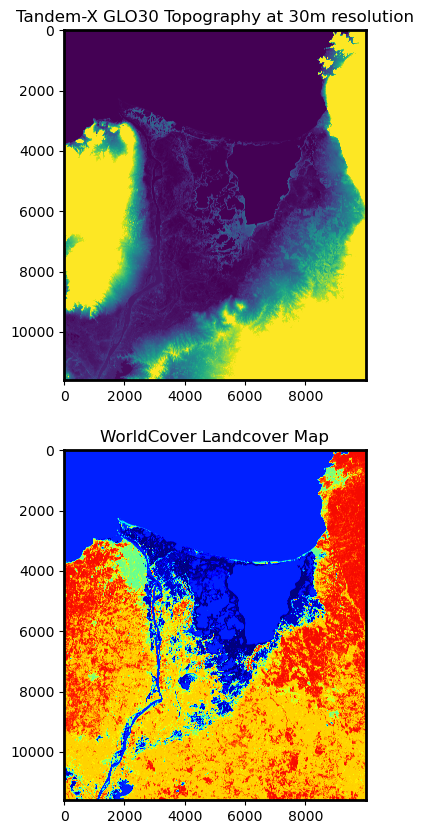

In [31]:
#ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
glo30 = rasterio.open(folders[8] / ('%s_GLO30_topo_%s.tif' %(AOI,res)))
landcover = rasterio.open(folders[8] / ('%s_WorldCover_%s.tif' %(AOI,res)))


fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(10,10))
ax1.imshow(glo30.read(1),vmin=0,vmax=50,cmap = 'viridis')
ax1.set_title('Tandem-X GLO30 Topography at 30m resolution')

ax2.imshow(landcover.read(1),cmap='jet_r')
ax2.set_title('WorldCover Landcover Map')


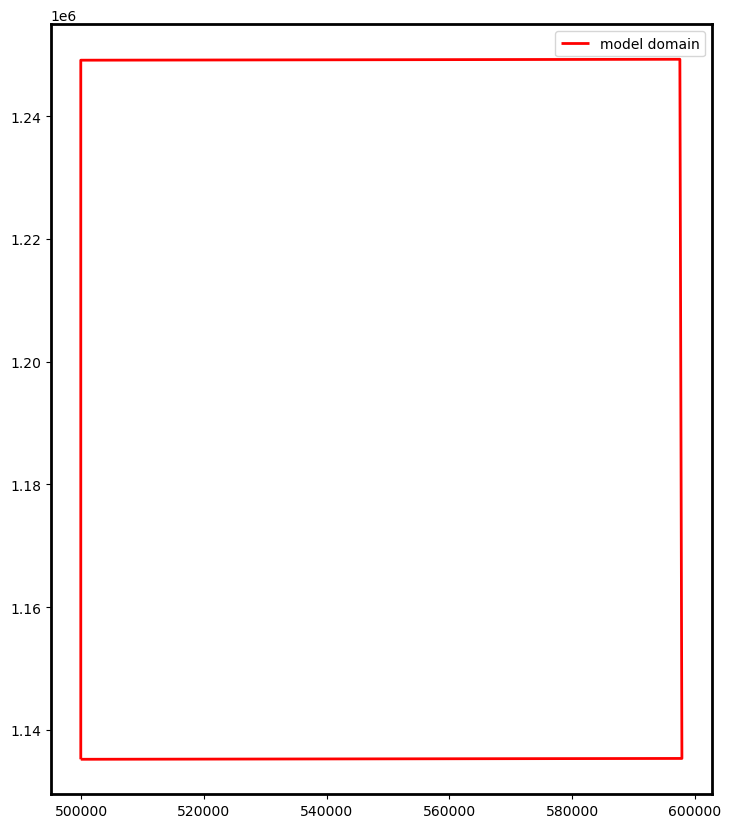

In [32]:
model_domain = gpd.read_file(folders[7] / ('%s_modeldomain.shp' %(AOI)))

fig,ax = plt.subplots(figsize=(10,10))
model_domain.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 2,ax=ax,label = 'model domain') #Use your second dataframe

plt.legend()

<font size='6' > Step #4: Clean the water mask </font> <br>
Clean, filter, smooth the water mask you made in the previous notebook </font>



In [33]:
#ref_10m = rasterio.open('%s/%s_GEBCO_10.tif' %(folders[8],AOI))
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,
                               True, 
                               False)
how_much_opening = 0
more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)





##############################################################################################
#################################[Step 3a][Make_Watermask]####################################
##############################################################################################


[Step 2][Setup_AOI_Files][Compiling Water Masks] .......

##################### Google Earth Engine water mask file : magdalena_ndvimin_ndwimin_clustered_finalwatermask.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9994P x 11605L.
Processing /Users/alchrist/Documents/GitHub/BAM/examples/magdalena/tmp/magdalena_ndvimin_ndwimin_clustered_finalwatermask.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 3A][Make_Watermask][Load Hydropolys] .......


[Step 3A][Make_Watermask][Load SWOT PLD lakes] .......


[Step 3A][Make_Watermask][Smoothing water and land masks] .......


[Step 3A][Make_Watermask][Start with the GEE watermask at

In [34]:
print(watermaskname)
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8]/ ("%s_watermask_10.tif " %(AOI)),folders[8] / ("%s_watermask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8] / ("%s_landmask_10.tif" %(AOI)),folders[8] / ("%s_landmask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))


magdalena_ndvimin_ndwimin_clustered_finalwatermask


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

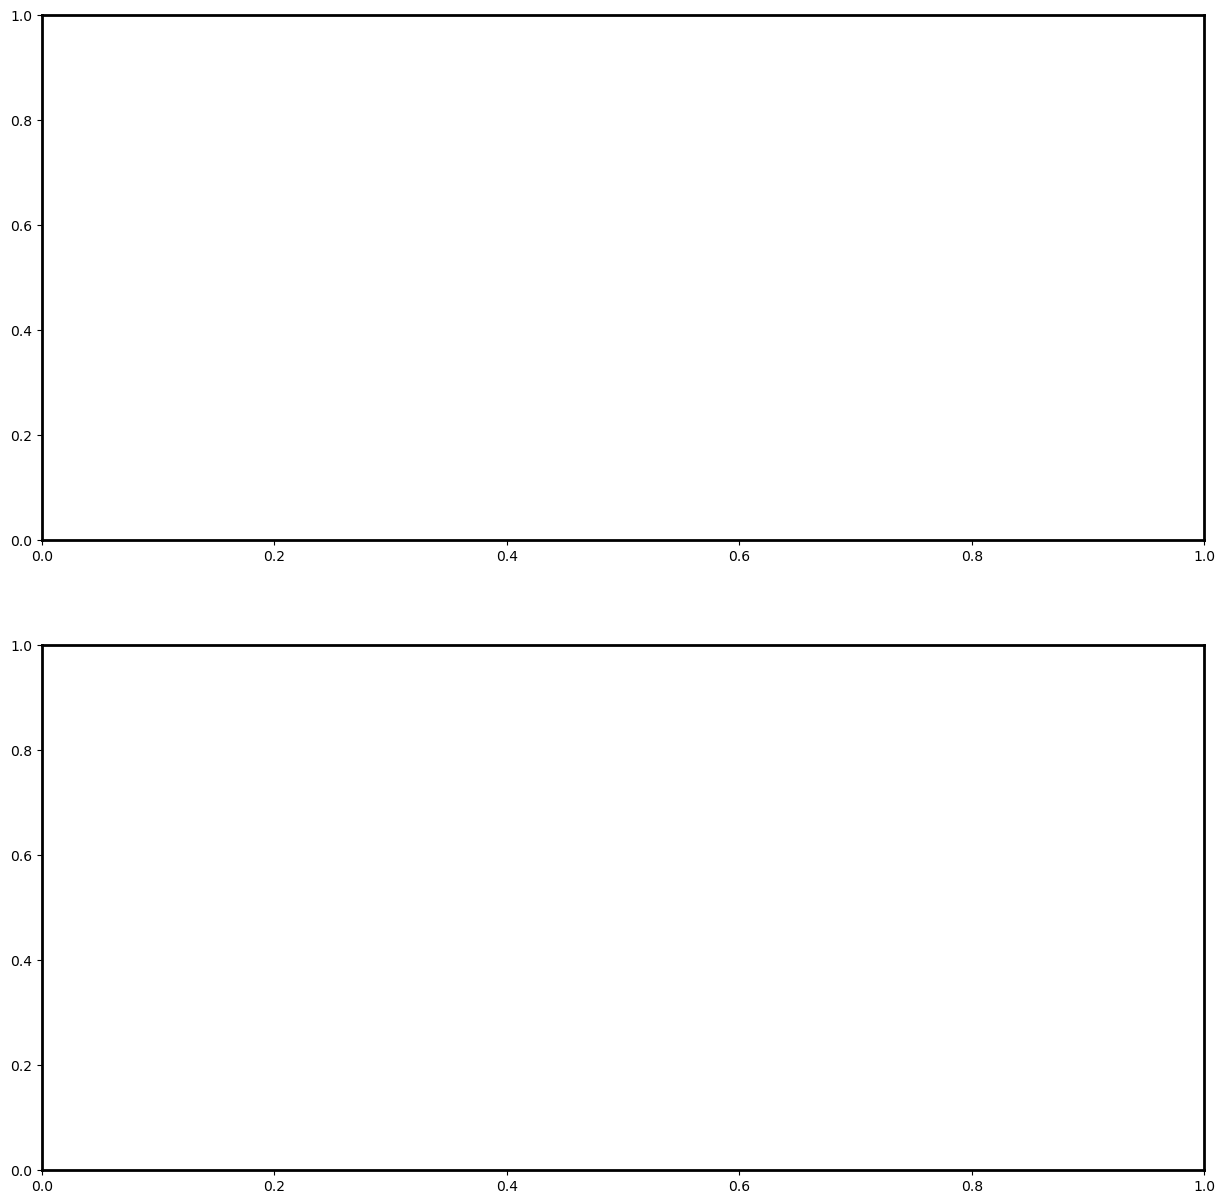

In [42]:
watermask = rasterio.open(folders[8] / ('%s_watermask_%s.tif' %(AOI,res))).read(1)

fig,ax1 = plt.subplots(nrows=2,figsize=(15,15))
ax1.imshow(watermask,'gray')


<font size='6' > Step #5: Make polygons of each land cover type <br> </font>
Ocean, lake, river, land


In [36]:
make_polygons(AOI,
            folders,
            parameters,
            ref,
            watermaskname,
            path_templates,
            os.path.isfile('%s_lands_%s.tif' %(folders[8]/AOI,res)))





##############################################################################################
################################[Step 4][Make_Polygons]######################################
##############################################################################################


[Step 4][Make_Polygons][Open land/water mask] .......

##################### Water delineated with magdalena_ndvimin_ndwimin_clustered_finalwatermask_10


ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
ERROR 1: Invalid index : 1
E


[Step 4][Make_Polygons][All initial water from Hydropolys and HydroLAKES] .......


[Step 4][Make_Polygons][Lakes from Hydropolys Type "Lake" and HydroLAKES] .......

##################### Lake polygons saved to /Setup_Files/Setup_SHPmagdalena_lakes_10.shp

[Step 4][Make_Polygons][Oceans from Hydropolys Type Ocean or Sea] .......

##################### Ocean polygons saved to /Setup_Files/Setup_SHPmagdalena_polygons_fulloceans_10.shp
0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 4][Make_Polygons][Ocean and lakes] .......

##################### Ocean and lake polygons saved to /Users/alchrist/Documents/GitHub/BAM/examples/magdalena/Setup_Files/Setup_SHP/magdalena_polygons_ocean_lakes_10.shp

[Step 4][Make_Polygons][Find connected water, starting with largest ocean polygon] .......

##################### All water connected to ocean polygons saved to /Setup_Files/Setup_SHPmagdalena_polygons_water_connected_10.shp

[Step 4][Make_Polygons][River from water that is no

/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/geopandas/geodataframe.py:206: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


##################### Land polygons saved to /Setup_Files/Setup_SHPmagdalena_polygons_lands_10.shp
##################### Rasterizing land, ocean, lake, and river polygons
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 4][Make_Polygons] Finished .......



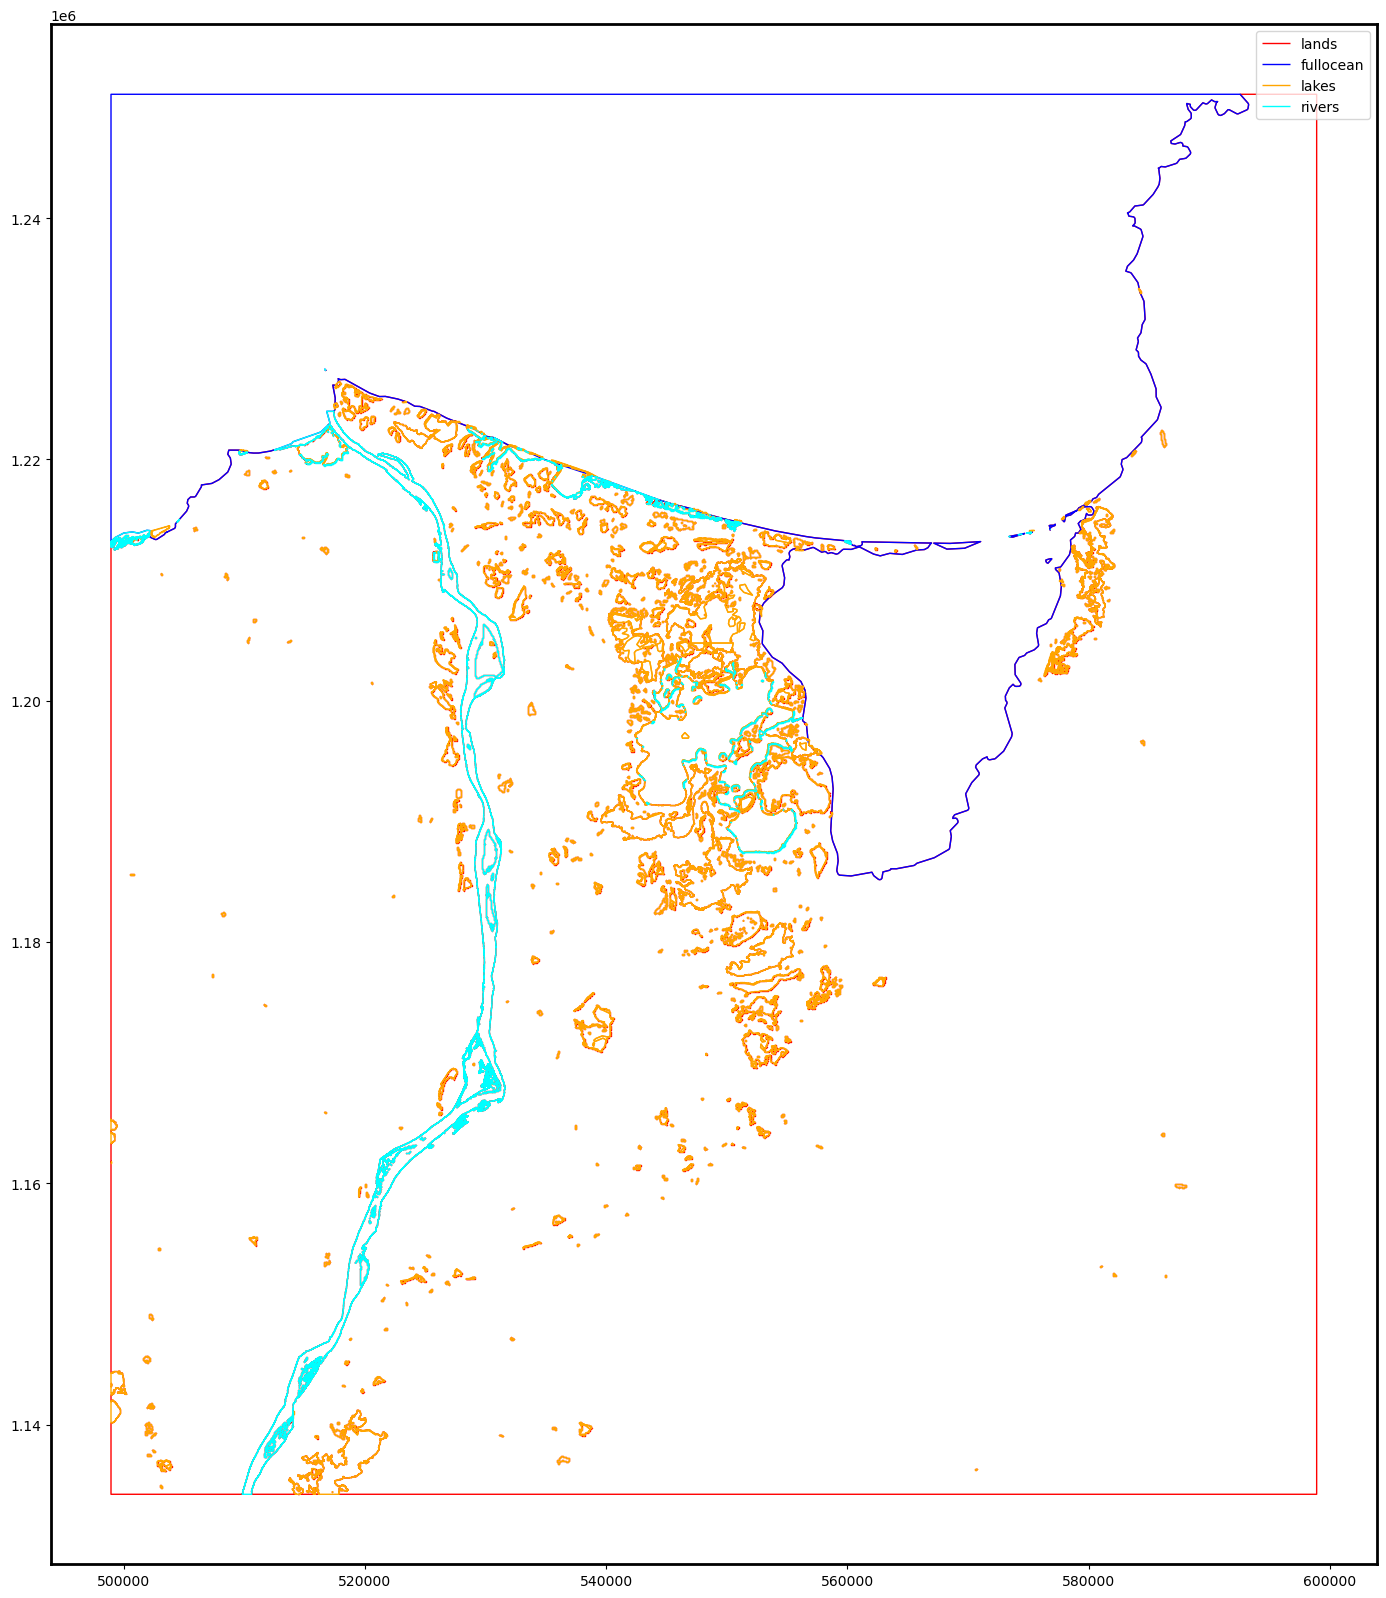

In [37]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    i=i+1
plt.legend()


<font size='6' > Step #6: Using Orinoco, get distance and width of the river networks</font>


In [38]:
segment_width = 20
pixel_step = int(round(segment_width/res))
try:
  distance = gdal.Open('%s_distance_%s.tif' %(folders[8] / AOI,res)).ReadAsArray()
  widths = gdal.Open('%s_widths_%sx%s.tif' %(folders[8] / AOI,res,pixel_step)).ReadAsArray()
except:
  distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,False)





##############################################################################################
##############################[Step 5][Make_Channel_Networks]#################################
##############################################################################################


[Step 5][Make_Channel_Networks][Import river mask (10m)] .......


[Step 5][Make_Channel_Networks][Import ocean mask (10m)] .......


[Step 5][Make_Channel_Networks][Use Orinoco code (Charlie) to get distance and widths of rivers] .......

##################### Pixel step will be 2
##################### Therefore, segments will be 10 * 2 = 20m wide

[Step 5][Make_Channel_Networks][Orinoco] .......


######[Make_Channel_Networks][Orinoco --> get_distance_in_channel] .......


######[Make_Channel_Networks][Orinoco --> get_distance_segments] .......


######[Make_Channel_Networks][Orinoco --> segment raster to shapefile] .......


######[Make_Channel_Networks][Orinoco --> get_undirected_channel_network] 

adding edges: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18105/18105 [00:00<00:00, 218810.24it/s]



######[Make_Channel_Networks][Orinoco --> add_flow_attributes] .......



flow vector computation using network: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 16327/16327 [00:01<00:00, 14834.65it/s]



######[Make_Channel_Networks][Orinoco --> get_geo_width_df] .......


######[Make_Channel_Networks][Orinoco --> update_graph_with_widths] .......


######[Make_Channel_Networks][Orinoco --> export_edges_to_geodataframe] .......


######[Make_Channel_Networks][Orinoco --> export_nodes_to_geodataframe] .......


######[Make_Channel_Networks][Orinoco --> get_width_features_from_segments] .......


######[Make_Channel_Networks][Orinoco --> get_array_from_features] .......

0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 5][Make_Channel_Networks][Finished] .......



<font size='6' > Step #7: Make the Digital Elevation Model </font>


In [39]:
elevation,elev_name = make_model_foundation(mounted_drive,
                                                parameters,
                                                AOI,
                                                folders,
                                                ref,
                                                distance,
                                                widths,
                                                watermask,pixel_step,mounted_drive)





##############################################################################################
###############################[Step 6][Make_Model_Foundation]################################
##############################################################################################


[Step 6][Make_Model_Foundation][Determine all methods for calculating elevation for each land/water type] .......

##################### Method for land = GLO30
##################### Method for ocean = GEBCO
##################### Method for lower river reaches = plane
##################### Method for upper river reaches = wdpower
##################### Method for lakes = constant_1
##################### Method for wetlands = constant_0
##################### Max Depth for Rivers = -3000
##################### Max Depth for Oceans = -3000
##################### Max Depth for Nearshore = -3000
##################### Boundary between Upper and Lower river reaches =  0m
/Users/alchrist/Documents/GitHub/BAM/exa

<font size=5 color='green'> We will use the elevation file in later notebooks. </font>

In [40]:
print(elev_name)


Elevation_ocean-GEBCO_land-GLO30_rivers-wdpower_wetland-uni00m_lakes-uni1m_10


<font size='6' > Step #6: Clean up temporary files </font> <br>


In [41]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done building DEM and other ancillary files. Move on to the next notebook 3_GetBoundaries.ipynb </font>
